In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import os
import shutil
import glob

from sklearn.model_selection import train_test_split

In [2]:
!pip install gdown

In [3]:
!gdown --id 1MzSemlod8Je5MN6iI8fMVlGnbI6d0xF1

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1MzSemlod8Je5MN6iI8fMVlGnbI6d0xF1
From (redirected): https://drive.google.com/uc?id=1MzSemlod8Je5MN6iI8fMVlGnbI6d0xF1&confirm=t&uuid=5c66c186-7cab-4009-95e3-ad1dcea6333d
To: /content/surface_crack.zip
100% 244M/244M [00:08<00:00, 27.6MB/s]


In [4]:
!unzip /content/surface_crack.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Positive/15001_1.jpg  
  inflating: /content/dataset/Positive/15002_1.jpg  
  inflating: /content/dataset/Positive/15003_1.jpg  
  inflating: /content/dataset/Positive/15004_1.jpg  
  inflating: /content/dataset/Positive/15005_1.jpg  
  inflating: /content/dataset/Positive/15006_1.jpg  
  inflating: /content/dataset/Positive/15007_1.jpg  
  inflating: /content/dataset/Positive/15008_1.jpg  
  inflating: /content/dataset/Positive/15009_1.jpg  
  inflating: /content/dataset/Positive/15010_1.jpg  
  inflating: /content/dataset/Positive/15011_1.jpg  
  inflating: /content/dataset/Positive/15012_1.jpg  
  inflating: /content/dataset/Positive/15013_1.jpg  
  inflating: /content/dataset/Positive/15014_1.jpg  
  inflating: /content/dataset/Positive/15015_1.jpg  
  inflating: /content/dataset/Positive/15016_1.jpg  
  inflating: /content/dataset/Positive/15017_1.jpg  
  inflating: /content/dataset/Positive/15018_1.j

In [5]:
!ls /content/dataset

Negative  Positive


In [6]:
data_path = '/content/dataset'

In [7]:
dataset_dir = "/content/dataset"
train_dir = "/content/dataset_split/train"
test_dir = "/content/dataset_split/test"

# Create directories
os.makedirs(train_dir + "/Positive", exist_ok=True)
os.makedirs(train_dir + "/Negative", exist_ok=True)
os.makedirs(test_dir + "/Positive", exist_ok=True)
os.makedirs(test_dir + "/Negative", exist_ok=True)

# Get all image files
positive_files = [os.path.join(dataset_dir, "Positive", f) for f in os.listdir(dataset_dir + "/Positive")]
negative_files = [os.path.join(dataset_dir, "Negative", f) for f in os.listdir(dataset_dir + "/Negative")]

# Split into train and test sets (e.g., 80% train, 20% test)
positive_train, positive_test = train_test_split(positive_files, test_size=0.2, random_state=42)
negative_train, negative_test = train_test_split(negative_files, test_size=0.2, random_state=42)
train_positive, val_positive = train_test_split(positive_train, test_size=0.2, random_state=42)
train_negative, val_negative = train_test_split(negative_train, test_size=0.2, random_state=42)

# Move files to validation directory
val_dir = "/content/dataset_split/val"
os.makedirs(val_dir + "/Positive", exist_ok=True)
os.makedirs(val_dir + "/Negative", exist_ok=True)

for file in val_positive:
    shutil.copy(file, os.path.join(val_dir, "Positive"))
for file in val_negative:
    shutil.copy(file, os.path.join(val_dir, "Negative"))

# Move files to train/test directories
for file in positive_train:
    shutil.copy(file, os.path.join(train_dir, "Positive"))
for file in positive_test:
    shutil.copy(file, os.path.join(test_dir, "Positive"))

for file in negative_train:
    shutil.copy(file, os.path.join(train_dir, "Negative"))
for file in negative_test:
    shutil.copy(file, os.path.join(test_dir, "Negative"))

In [8]:
positive_path = os.path.join(data_path, "Positive/")
negative_path = os.path.join(data_path, "Negative/")

In [9]:
len(os.listdir(positive_path))

20000

In [10]:
positive_files = glob.glob(positive_path + "*.jpg")
negative_files = glob.glob(negative_path + "*.jpg")

In [11]:
positive_pic = cv2.imread(positive_files[2])
negative_pic = cv2.imread(negative_files[15])

In [12]:
positive_pic.shape, negative_pic.shape

((227, 227, 3), (227, 227, 3))

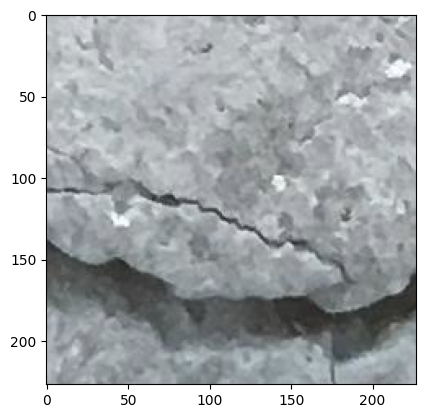

In [13]:
plt.imshow(positive_pic)

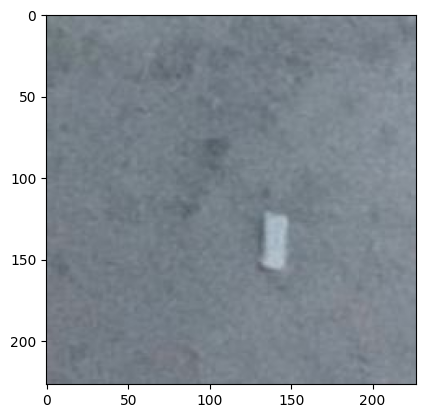

In [14]:
plt.imshow(negative_pic)

In [15]:
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim

In [16]:
class SurfaceCrackDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []
        for label, folder in enumerate(["Negative", "Positive"]):
            folder_path = os.path.join(directory, folder)
            for file in os.listdir(folder_path):
                self.images.append(os.path.join(folder_path, file))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [17]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = SurfaceCrackDataset(train_dir, transform=transform)
test_dataset = SurfaceCrackDataset(test_dir, transform=transform)
val_dataset = SurfaceCrackDataset(val_dir, transform=transform)

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 55 * 55, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Train Acc: {train_accuracies[-1]}, "
          f"Val Loss: {val_losses[-1]}, Val Acc: {val_accuracies[-1]}")

Epoch 1/10, Train Loss: 0.20657136122581868, Train Acc: 0.976875, Val Loss: 0.03690897431515623, Val Acc: 0.98796875
Epoch 2/10, Train Loss: 0.051905671928700034, Train Acc: 0.9894375, Val Loss: 0.03546560988092096, Val Acc: 0.99140625
Epoch 3/10, Train Loss: 0.03306654559083108, Train Acc: 0.9916875, Val Loss: 0.07779876299249092, Val Acc: 0.99234375
Epoch 4/10, Train Loss: 0.030370729684342224, Train Acc: 0.992375, Val Loss: 0.019359989669849257, Val Acc: 0.994375
Epoch 5/10, Train Loss: 0.028167212018772262, Train Acc: 0.99409375, Val Loss: 0.015262402579107288, Val Acc: 0.995
Epoch 6/10, Train Loss: 0.02326494797122905, Train Acc: 0.99521875, Val Loss: 0.0206601334843117, Val Acc: 0.9934375
Epoch 7/10, Train Loss: 0.023309607087088808, Train Acc: 0.9946875, Val Loss: 0.024316822623259213, Val Acc: 0.994375
Epoch 8/10, Train Loss: 0.04195333414923618, Train Acc: 0.9940625, Val Loss: 0.019056929469327456, Val Acc: 0.99484375
Epoch 9/10, Train Loss: 0.015377177036138164, Train Acc: 0.

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Test Accuracy: {correct/total}")

Test Accuracy: 0.995875


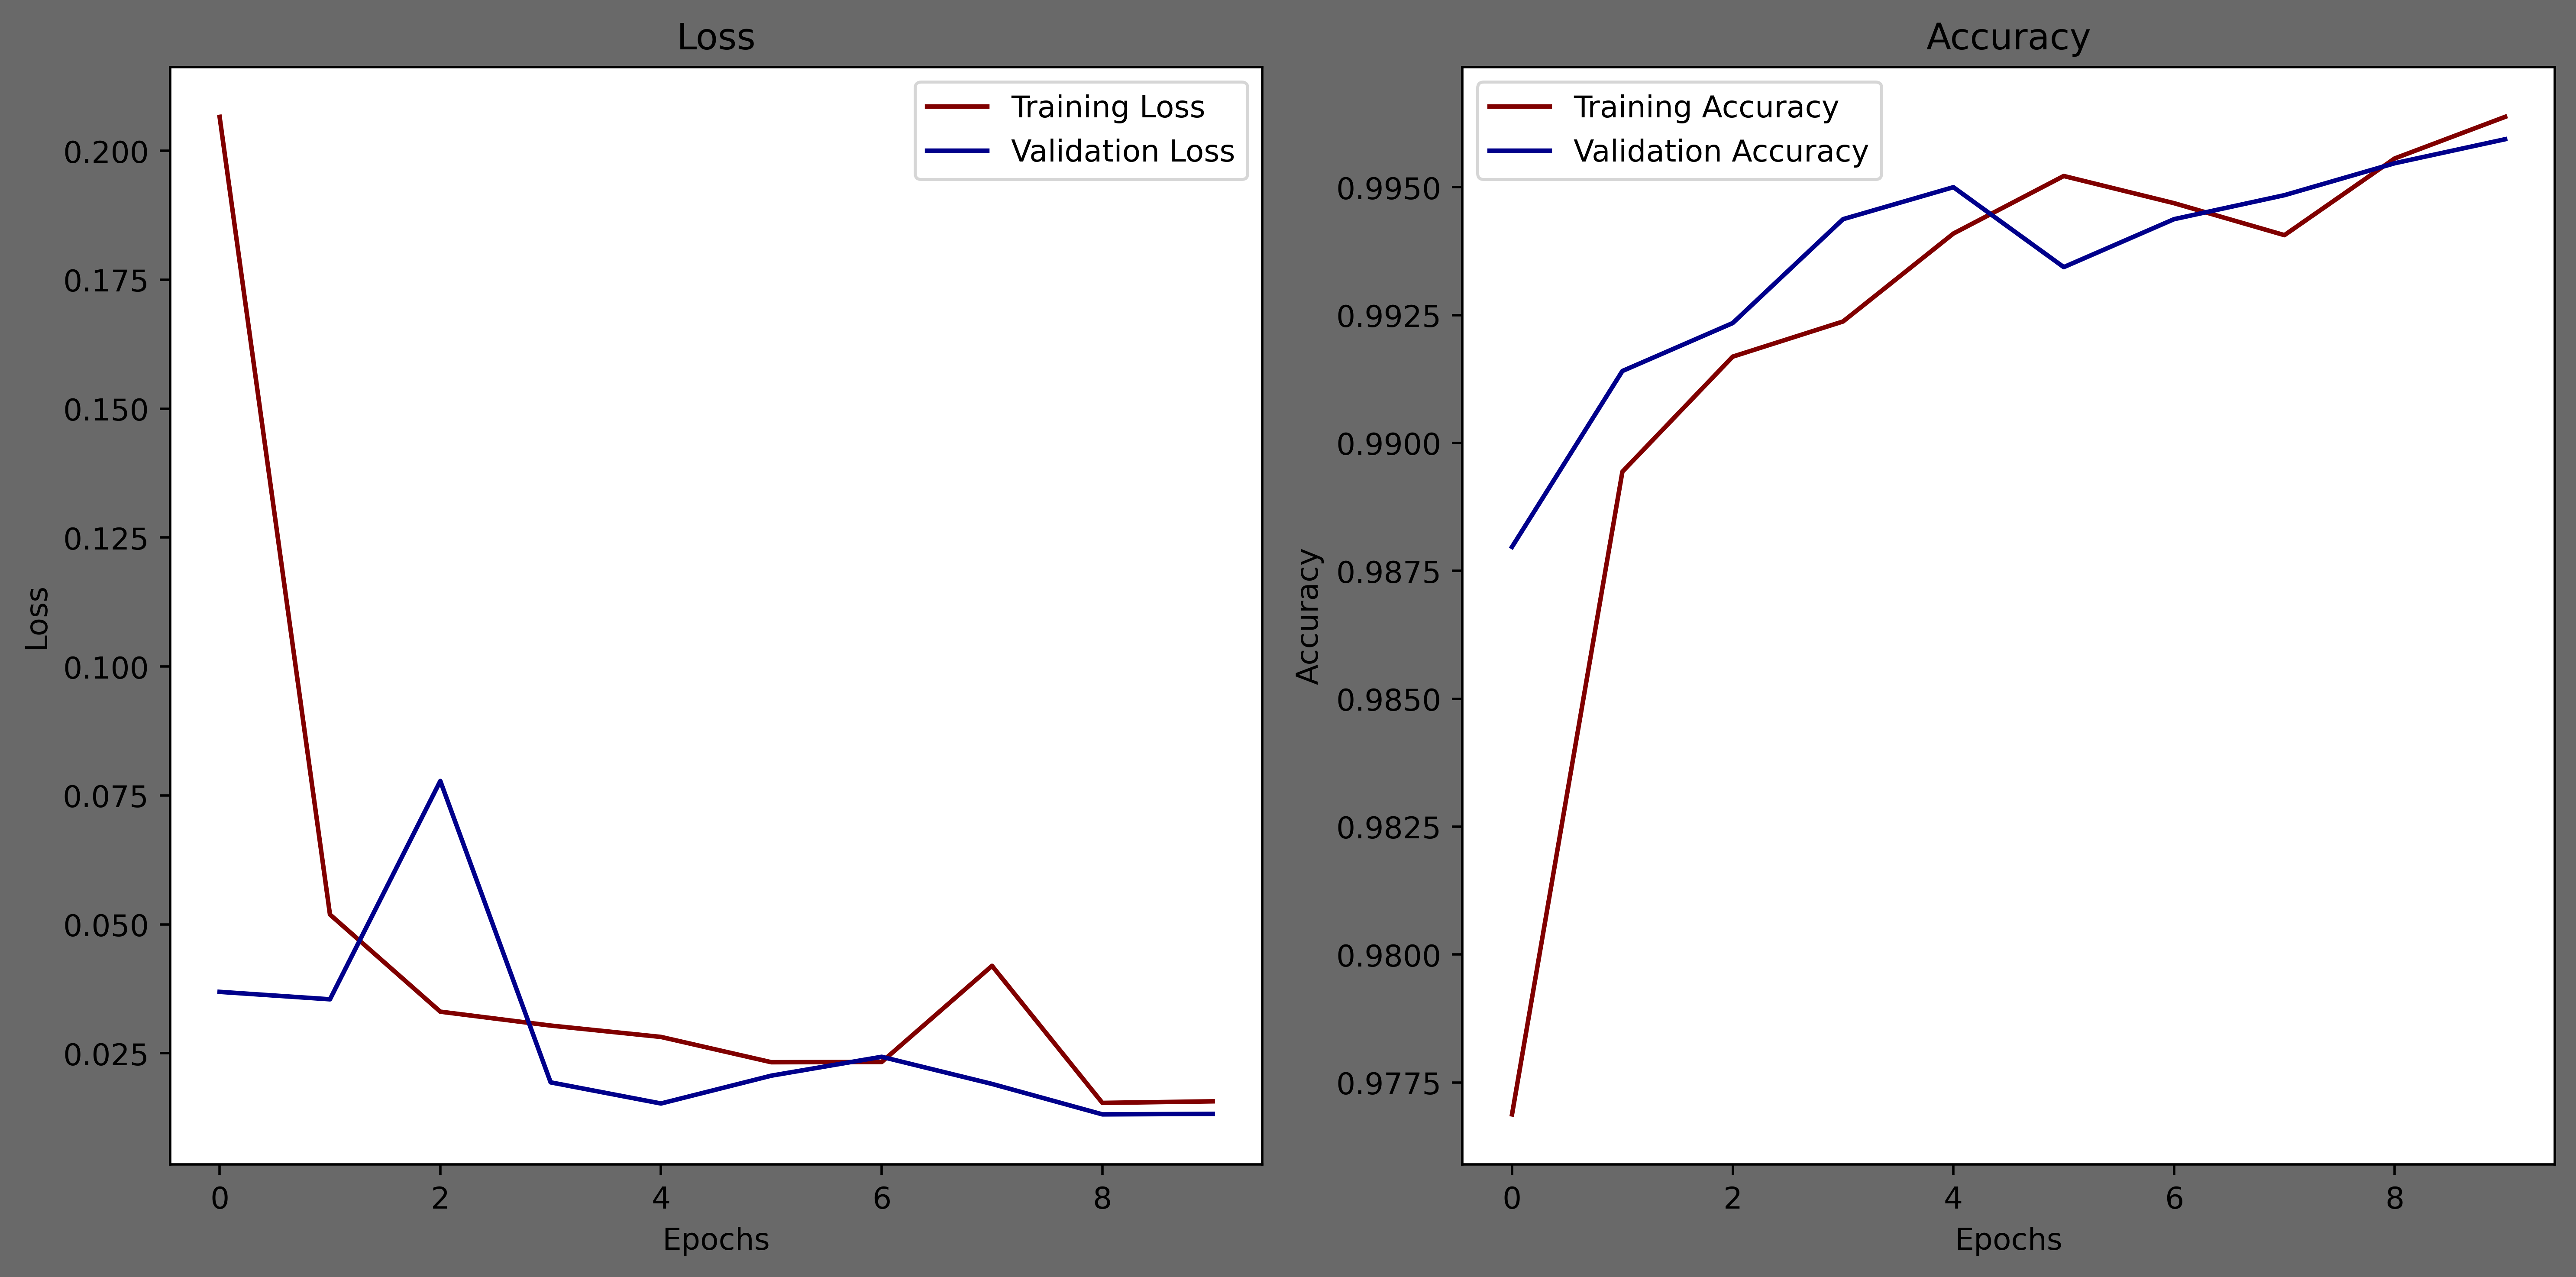

In [26]:
fig = plt.figure(figsize=(12, 6), facecolor='dimgrey', dpi=500)

# Plot Loss
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_losses, label='Training Loss', c='maroon')
ax1.plot(val_losses, label='Validation Loss', c='darkblue')
ax1.set(
    title = 'Loss',
    xlabel = 'Epochs',
    ylabel = 'Loss'
)
ax1.legend()


# Plot Accuracy
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(train_accuracies, label='Training Accuracy', c='maroon')
ax2.plot(val_accuracies, label='Validation Accuracy', c='darkblue')
ax2.set(
    title = 'Accuracy',
    xlabel = 'Epochs',
    ylabel = 'Accuracy'
)
ax2.legend()

plt.tight_layout()
plt.show()